In [1]:
%load_ext autoreload
%autoreload 
%matplotlib inline

# ML Pipeline — Time Series Classification


In [2]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

## Imports
Libraries for data handling, modeling, validation, and optimization.

In [3]:
import json
import joblib # type: ignore
import numpy as np # type: ignore
import pandas as pd # type: ignore

from sklearn import metrics # type: ignore
from sklearn.ensemble import ( # type: ignore
    GradientBoostingClassifier,
    VotingClassifier
)
from sklearn.impute import SimpleImputer # type: ignore
from sklearn.metrics import ( # type: ignore
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    classification_report,
)
from sklearn.model_selection import TimeSeriesSplit, cross_val_score # type: ignore

from sklearn.pipeline import Pipeline # type: ignore
from sklearn.svm import SVC # type: ignore

import matplotlib.pyplot as plt

from catboost import CatBoostClassifier # type: ignore
import optuna # type: ignore

from kit import Data
from kit.plot import shap_catboost , run_multi_threshold_backtest,calculate_and_plot_permutation_importance,display_confusion_matrix
from kit.prep import fillna, columns_drop, apply_log, create_features, Scaler, categorize_y,drop_flat_rows

## Preprocessing

In [4]:
def process(filename, folder):
    """
    Loads raw time-series data and performs a complete preprocessing and feature engineering workflow,
    culminating in the creation of training and testing sets.

    The workflow includes data transformation, cleaning, feature generation, target categorization,
    and a chronological train/test split (95/5).
    
    Args:
        filename (str): The name of the CSV file containing the raw data.
        folder (str): The path to the folder where the file is located.

    Returns:
        tuple: A tuple containing (X_train, y_train, X_test, y_test) ready for model training.
    """
    loader = Data.Data(filename, folder)
    df = loader.data

    df = apply_log(df)
    
    df = drop_flat_rows(df, threshold=0.7)

    df = create_features(df, price_col='forward_returns')
    
    df['target'] = categorize_y(df['forward_returns'], bin=0.003)

    df = fillna(df)
    
    df = df.dropna(subset=['target'])


    split_idx = int(len(df) * 0.95)
    train = df.iloc[:split_idx]
    test = df.iloc[split_idx:]
    
    cols_to_drop = [
        'date_id', 'forward_returns', 'market_forward_excess_returns',
        'E7', 'M1', 'M13', 'M2', 'S3', 'V10', 'date_id'
    ]

    X_train, y_train = columns_drop(train, droplist=cols_to_drop, y_field='target')
    X_test, y_test = columns_drop(test, droplist=cols_to_drop, y_field='target')

    y_train = y_train.astype(int)
    y_test = y_test.astype(int)

    return X_train, y_train, X_test, y_test

## Train / Test Split
Time-based split:
- 95% train
- 5% test

In [5]:
X_train, y_train, X_test, y_test = process("train.csv", "../Data")

In [6]:
PARAMS_FILE = "best_params_optuna.json"

def save_params(params, filename):
        with open(filename, 'w') as f:
            json.dump(params, f, indent=4)

# Hyperparameter Tuning (Optuna)

In [ ]:
def objective(trial):
    """
    Tune hyperparameters for CatBoost, SVM, or GradientBoosting with Optuna.

    Args:
        trial: Optuna trial containing the selected model name and search space.

    Returns:
        Mean accuracy over a 3-split TimeSeriesSplit.
    """
    model_name = trial.user_attrs["model_name"]
    
    if model_name == 'CatBoost':
        params = {
            'iterations': trial.suggest_int('iterations', 100, 800),
            'depth': trial.suggest_int('depth', 4, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
            'verbose': 0, 
            'allow_writing_files': False, 
            'thread_count': -1
        }
        pipe = Pipeline([('model', CatBoostClassifier(**params))])

    elif model_name == 'SVM':
        params = {
            'C': trial.suggest_float('C', 0.1, 100, log=True),
            'gamma': trial.suggest_categorical('gamma', ['scale', 'auto', 0.1, 0.01]),
            'kernel': 'rbf', 
            'class_weight': 'balanced', 
            'probability': True, 
            'cache_size': 1000
        }
        pipe = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', Scaler(limits=(0.01, 0.99))),
            ('model', SVC(**params))
        ])

    elif model_name == 'GradientBoosting':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 8),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'random_state': 42
        }
        pipe = Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
            ('model', GradientBoostingClassifier(**params))
        ])

    tscv = TimeSeriesSplit(n_splits=3)
    scores = cross_val_score(pipe, X_train, y_train, cv=tscv, scoring='accuracy', n_jobs=-1)
    return scores.mean()

models_to_tune = ['CatBoost', 'SVM', 'GradientBoosting']
best_params_found = {}

optuna.logging.set_verbosity(optuna.logging.WARNING)

for model in models_to_tune:
    study = optuna.create_study(direction='maximize')
    study.enqueue_trial({}) 
    study.set_user_attr("model_name", model)
    
    def func(trial):
        trial.set_user_attr("model_name", model)
        return objective(trial)
    study.optimize(func, n_trials=40)
    best_params_found[model] = study.best_params

save_params(best_params_found, PARAMS_FILE)

# Final Models & Ensemble

## Pipelines

In [7]:
with open("best_params_tuned.json", 'r') as f:
    tuned_params = json.load(f)

class CatBoostFlat(CatBoostClassifier): #ensures predict() returns a flat array.
    _estimator_type = "classifier"
    def predict(self, data, **kwargs):
        return np.array(super().predict(data, **kwargs)).ravel()

cat_p = tuned_params['CatBoost']
cat_p.update({'verbose': 0, 'allow_writing_files': False, 'thread_count': -1,'random_state': 42 })
pipe_cat = Pipeline([('model', CatBoostFlat(**cat_p))])

svm_p = tuned_params['SVM']
svm_p.update({'probability': True, 'class_weight': 'balanced'})
pipe_svm = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', Scaler(limits=(0.01, 0.99))),
    ('model', SVC(**svm_p))
])

gb_p = tuned_params['GradientBoosting']
gb_p.update({'random_state': 42})  
pipe_gb = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('model', GradientBoostingClassifier(**gb_p))
])

## CV Strategy

In [ ]:
def objective_weights(trial):
    """
    Tune soft-voting weights for CatBoost, SVM, and Gradient Boosting with Optuna.
    Args:
        trial: Optuna trial used to sample integer weights.
    Returns:
        Mean accuracy over a 5-split time series cross-validation.
    """
    w_cat = trial.suggest_int('w_catboost', 1, 10)
    w_svm = trial.suggest_int('w_svm', 1, 10)
    w_gb = trial.suggest_int('w_gb', 1, 10)

    weights = [w_cat, w_svm, w_gb]

    current_vote_soft = VotingClassifier(
        estimators=[('cat', pipe_cat), ('svm', pipe_svm), ('gb', pipe_gb)],
        voting='soft',
        weights=weights,
        n_jobs=-1
    )

    tscv = TimeSeriesSplit(n_splits=5) 
    
    scores = cross_val_score(
        current_vote_soft, 
        X_train, 
        y_train, 
        cv=tscv,
        scoring='accuracy', 
        n_jobs=-1
    )
    
    return scores.mean()


study_weights = optuna.create_study(direction='maximize')
study_weights.optimize(objective_weights, n_trials=30, show_progress_bar=True) 

best_weights = study_weights.best_params
best_f1_score = study_weights.best_value

w_cat_opt = best_weights['w_catboost']
w_svm_opt = best_weights['w_svm']
w_gb_opt = best_weights['w_gb']

vote_soft = VotingClassifier(
    estimators=[('cat', pipe_cat), ('svm', pipe_svm), ('gb', pipe_gb)],
    voting='soft',
    weights=[w_cat_opt, w_svm_opt, w_gb_opt],
    n_jobs=-1
)

[I 2025-12-07 16:30:26,738] A new study created in memory with name: no-name-4d7eaead-690a-452d-8de4-5de5f9eb0b38


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-12-07 16:31:06,713] Trial 0 finished with value: 0.3843991567111736 and parameters: {'w_catboost': 9, 'w_svm': 8, 'w_gb': 1}. Best is trial 0 with value: 0.3843991567111736.
[I 2025-12-07 16:31:46,203] Trial 1 finished with value: 0.3821503865073788 and parameters: {'w_catboost': 10, 'w_svm': 9, 'w_gb': 1}. Best is trial 0 with value: 0.3843991567111736.
[I 2025-12-07 16:32:25,692] Trial 2 finished with value: 0.38805340829234014 and parameters: {'w_catboost': 6, 'w_svm': 8, 'w_gb': 8}. Best is trial 2 with value: 0.38805340829234014.
[I 2025-12-07 16:33:04,488] Trial 3 finished with value: 0.3723120168657765 and parameters: {'w_catboost': 1, 'w_svm': 9, 'w_gb': 3}. Best is trial 2 with value: 0.38805340829234014.
[I 2025-12-07 16:33:43,462] Trial 4 finished with value: 0.38144764581869295 and parameters: {'w_catboost': 4, 'w_svm': 7, 'w_gb': 10}. Best is trial 2 with value: 0.38805340829234014.
[I 2025-12-07 16:34:21,875] Trial 5 finished with value: 0.380744905130007 and para

In [24]:
best_weights = {'w_catboost': 10, 'w_svm': 1, 'w_gb': 4} # from one  optuna

{'w_catboost': 10, 'w_svm': 1, 'w_gb': 4}

In [ ]:
w_cat_opt = best_weights['w_catboost']
w_svm_opt = best_weights['w_svm']
w_gb_opt = best_weights['w_gb']

vote_soft = VotingClassifier(
    estimators=[('cat', pipe_cat), ('svm', pipe_svm), ('gb', pipe_gb)],
    voting='soft',
    weights=[w_cat_opt, w_svm_opt, w_gb_opt],
    n_jobs=-1
)

In [9]:
models = {
    'Voting Soft': vote_soft,
    'CatBoost': pipe_cat,
    'SVM': pipe_svm,
    'GradientBoost': pipe_gb,
}

In [23]:
def cv_all_models(models_dict, X, y, n_splits=5, filename="cv_results.csv"):
    """
    Performs Time Series Cross-Validation (TSCV) for all models in the provided dictionary.
    Evaluates each model's stability and mean performance using TimeSeriesSplit on the provided data (X, y).
    """
    tscv = TimeSeriesSplit(n_splits=n_splits)

    results = []

    for name, model in models_dict.items():

        scores = cross_val_score(
            model,
            X,
            y,
            cv=tscv,
            scoring='accuracy',
            n_jobs=-1
        )

        results.append({
            "Model": name,
            "CV Mean Accuracy": np.mean(scores),
            "CV Std": np.std(scores),
            "CV Min Accuracy": np.min(scores)
        })

    df_cv = pd.DataFrame(results).set_index("Model")

    display(df_cv.style.format({
        "CV Mean Accuracy": "{:.2%}",
        "CV Std": "{:.2%}",
        "CV Min Accuracy": "{:.2%}"
    }))

    df_cv.to_csv(filename)

    return df_cv


cv_results = cv_all_models(models, X_train, y_train, n_splits=5)

,CV Mean Accuracy,CV Std,CV Min Accuracy
Model,,,
Voting Soft,39.85%,3.45%,36.05%
CatBoost,40.14%,4.01%,33.17%
SVM,37.57%,5.18%,28.32%
GradientBoost,38.89%,3.15%,33.73%


# Test Evaluation

In [11]:
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred, average='macro'),
        'Precision': precision_score(y_test, y_pred, average='macro'),
        'F1-Score': f1_score(y_test, y_pred, average='macro')
    })

df_final = pd.DataFrame(results).set_index('Model').sort_values(by='Accuracy', ascending=False)
df_final.to_csv("test_on_test.csv")

df_final.style.format("{:.2%}")\
    .background_gradient(cmap='RdYlGn', subset=['Accuracy', 'F1-Score','Recall','Precision'])

,Accuracy,Recall,Precision,F1-Score
Model,,,,
CatBoost,46.44%,41.91%,42.41%,35.77%
Voting Soft,45.56%,41.14%,41.91%,35.07%
GradientBoost,45.33%,42.09%,41.51%,39.12%
SVM,40.44%,37.76%,36.11%,32.80%


In [12]:
def display_metrics(y_test, y_pred):
    acc = metrics.accuracy_score(y_test, y_pred)
    rec = metrics.recall_score(y_test, y_pred, average='macro')
    prc = metrics.precision_score(y_test, y_pred, average='macro')
    f1  = metrics.f1_score(y_test, y_pred, average='macro')
    
    print('Accuracy    : {:.2f}%'.format(acc*100))
    print('Recall      : {:.2f}%'.format(rec*100))
    print('Precision   : {:.2f}%'.format(prc*100))
    print('F1-score    : {:.2f}%'.format(f1*100))

In [13]:
vote_soft.fit(X_train, y_train)
y_pred = vote_soft.predict(X_test)

display_metrics(y_test , y_pred)

Accuracy    : 45.56%
Recall      : 41.14%
Precision   : 41.91%
F1-score    : 35.07%


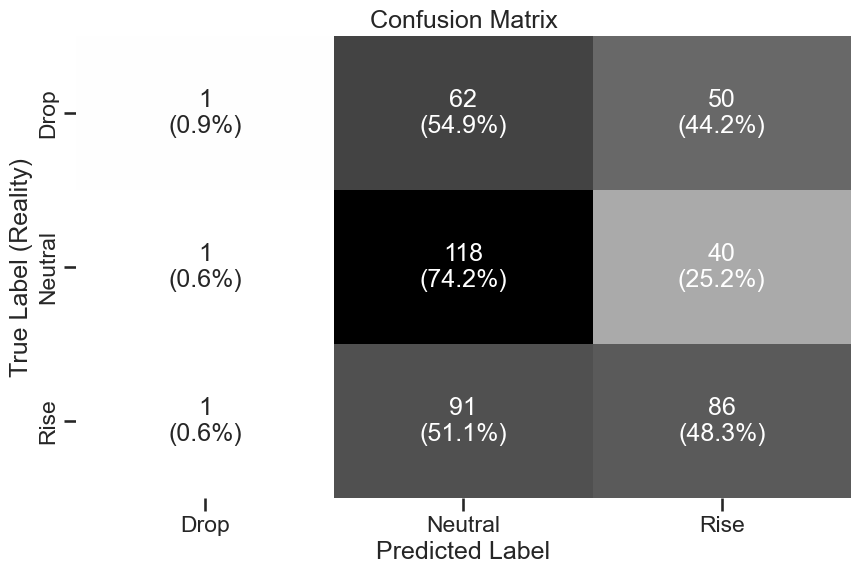

              precision    recall  f1-score   support

        Drop       0.33      0.01      0.02       113
     Neutral       0.44      0.74      0.55       159
        Rise       0.49      0.48      0.49       178

    accuracy                           0.46       450
   macro avg       0.42      0.41      0.35       450
weighted avg       0.43      0.46      0.39       450



In [25]:
y_pred = vote_soft.predict(X_test)
labels_simple = ['Drop', 'Neutral', 'Rise']

display_confusion_matrix(
    y_test, 
    y_pred, 
    title='Confusion Matrix',
    labels=labels_simple,
    cmap="binary",
)

print(classification_report(y_test, y_pred, target_names=labels_simple))

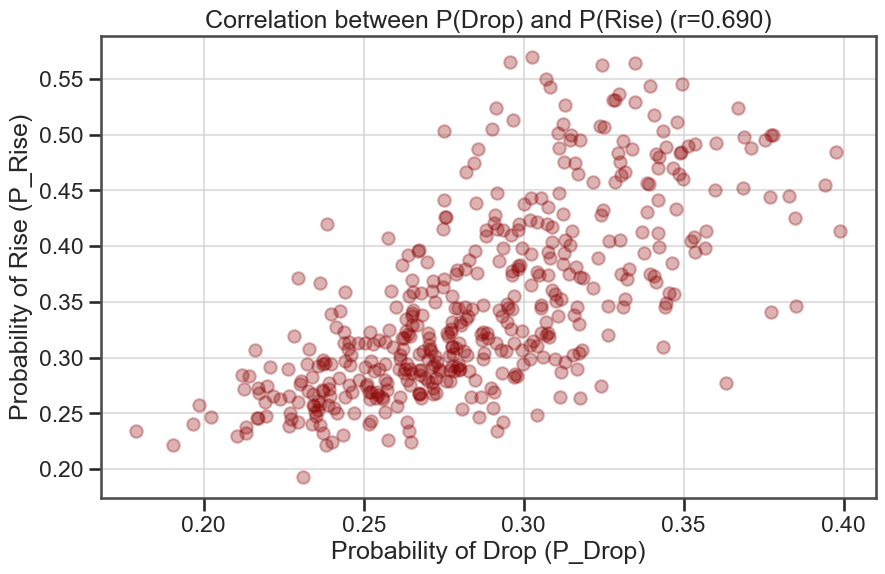

,P_Drop (Class 0),P_Rise (Class 2),P_Neutral (Class 1)
178,0.399,0.413,0.188
349,0.398,0.485,0.118
176,0.394,0.455,0.151
270,0.385,0.347,0.268
281,0.385,0.425,0.190


In [33]:
probas = vote_soft.predict_proba(X_test)

p_drop = probas[:, 0]
p_rise = probas[:, 2]

correlation_matrix = np.corrcoef(p_drop, p_rise)
correlation_pr = correlation_matrix[0, 1]

df_probas = pd.DataFrame({
    'P_Drop (Class 0)': p_drop,
    'P_Rise (Class 2)': p_rise,
    'P_Neutral (Class 1)': probas[:, 1]
})

plt.figure()
plt.scatter(df_probas['P_Drop (Class 0)'], df_probas['P_Rise (Class 2)'], alpha=0.3, color='darkred')
plt.title(f"Correlation between P(Drop) and P(Rise) (r={correlation_pr:.3f})")
plt.xlabel("Probability of Drop (P_Drop)")
plt.ylabel("Probability of Rise (P_Rise)")
plt.show()

high_volatility_cases = df_probas[
    (df_probas['P_Drop (Class 0)'] > 0.30) & 
    (df_probas['P_Rise (Class 2)'] > 0.30)
].sort_values(by='P_Drop (Class 0)', ascending=False).head(5)
display(high_volatility_cases.style.format("{:.3f}"))


# Threshold-Based Prediction


Our custom threshold adjusts this: it forces the prediction to Drop (Class 0) if its predicted probability (PDrop) exceeds a certain threshold (e.g., 0.34), regardless of whether another class has a slightly higher probability.

In [15]:
def predict_with_threshold(model, X, threshold_low=0.34):
    """
    Applies a custom threshold rule to favor the 'Drop' class (0).
    If the probability of 'Drop' (p[0]) exceeds the threshold, the prediction is forced to 0.
    Otherwise, the model predicts the most likely class between 'Neutral' (1) and 'Rise' (2).
    """
    probas = model.predict_proba(X)
    final_preds = []
    
    for p in probas:
        prob_baisse = p[0]
        if prob_baisse > threshold_low:
            final_preds.append(0) 
        else:
            final_preds.append(np.argmax(p[1:]) + 1)
            
    return np.array(final_preds)

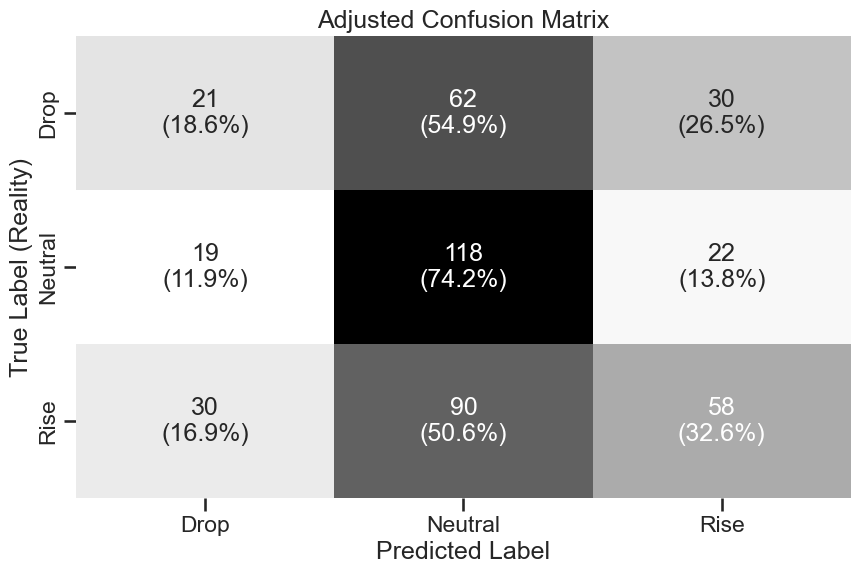

              precision    recall  f1-score   support

        Drop       0.30      0.19      0.23       113
     Neutral       0.44      0.74      0.55       159
        Rise       0.53      0.33      0.40       178

    accuracy                           0.44       450
   macro avg       0.42      0.42      0.39       450
weighted avg       0.44      0.44      0.41       450



In [26]:
y_pred_final = predict_with_threshold(vote_soft, X_test, threshold_low=0.33)

display_confusion_matrix(
    y_test, 
    y_pred_final, 
    title='Adjusted Confusion Matrix',
    labels=labels_simple,
    cmap="binary",
)

print(classification_report(y_test, y_pred_final, target_names=labels_simple))

In [17]:
display_metrics(y_test , y_pred_final)

Accuracy    : 43.78%
Recall      : 41.79%
Precision   : 42.14%
F1-score    : 39.41%


Applying the prediction threshold improved the F1-score by 5 percentage points but resulted in a slight decrease in overall accuracy.

# Backtest

In [18]:
loader = Data.Data("train.csv", "../Data")
df_full = loader.data

## Multi-Threshold Strategy Test

,Total Return,Sharpe Ratio,Annualized Volatility,Max Drawdown
Strategy,,,,
Model (thr=0.32),44.73%,1.55,10.68%,-9.40%
Model (thr=0.33),46.21%,1.50,11.53%,-10.97%
Model (thr=0.34),54.55%,1.67,12.29%,-11.91%
Model (thr=0.35),74.74%,2.12,12.97%,-10.00%
Market (Buy & Hold),44.03%,1.16,14.50%,-18.04%


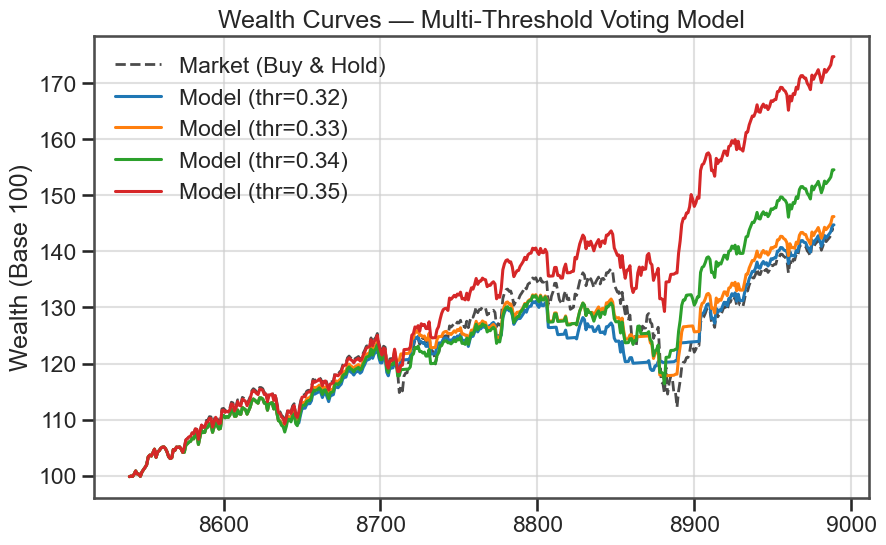

In [19]:
run_multi_threshold_backtest(vote_soft, X_test, df_full)

## Model Saving

In [20]:
joblib.dump(vote_soft,"model_voting_soft.pkl")

['model_voting_soft.pkl']

# Explainability

## Permutation Importance

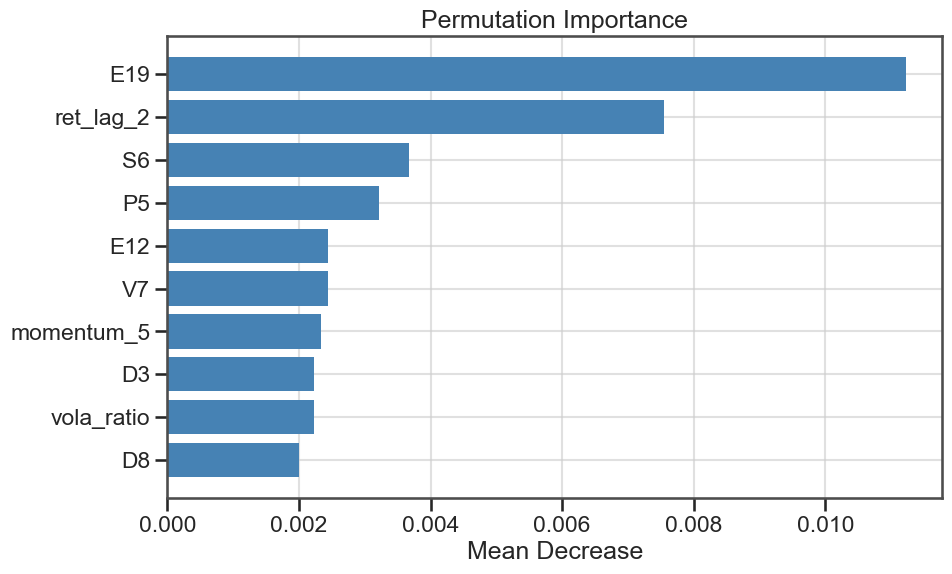

In [37]:
df_importance_final = calculate_and_plot_permutation_importance(vote_soft, X_test, y_test)

## SHAP (CatBoost)

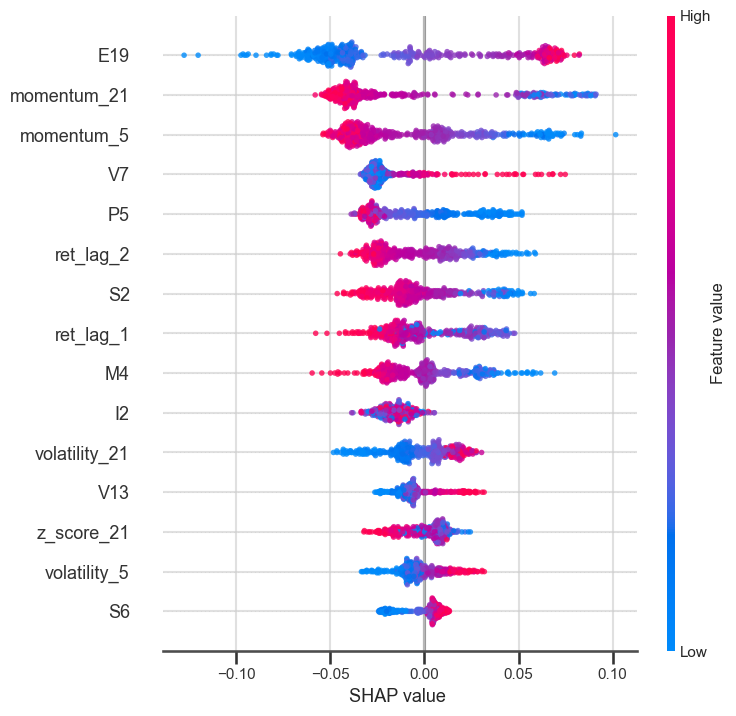

(array([[[ 8.04410714e-05,  2.50608831e-04, -1.89489020e-04, ...,
          -8.72984583e-03, -3.03554465e-02,  4.02847026e-03],
         [ 8.04410714e-05,  4.43353609e-04, -6.60462593e-05, ...,
          -1.34001919e-03, -3.47235368e-02, -1.38778566e-03],
         [ 8.04410714e-05,  4.47612107e-04, -1.89489020e-04, ...,
           1.26732183e-03, -3.28457481e-02,  1.76667243e-04],
         ...,
         [ 1.10122984e-04,  2.73191087e-04, -2.21895654e-04, ...,
          -6.74741853e-03,  4.57077462e-02,  1.18289082e-03],
         [ 1.10122984e-04,  1.99641019e-04, -1.29110335e-04, ...,
           1.53436356e-02,  1.31768537e-02,  3.81490230e-03],
         [ 8.04410714e-05,  3.75806344e-04, -1.93322841e-04, ...,
          -7.51334943e-03,  7.01970752e-02, -7.52985169e-04]],
 
        [[ 1.91253281e-05,  5.41435439e-04,  5.18926011e-04, ...,
           2.88137890e-02,  6.84737430e-02,  3.89722389e-03],
         [ 1.91253281e-05,  5.25642597e-04,  1.96555153e-04, ...,
           4.93900751

In [22]:
shap_catboost(vote_soft, X_test,classe=2) # 2 for rise

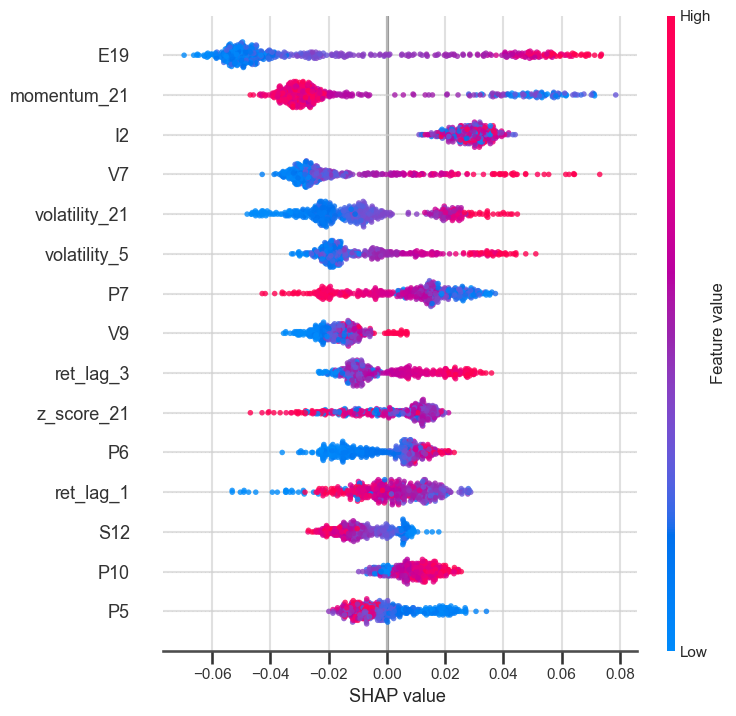

(array([[[ 8.04410714e-05,  2.50608831e-04, -1.89489020e-04, ...,
          -8.72984583e-03, -3.03554465e-02,  4.02847026e-03],
         [ 8.04410714e-05,  4.43353609e-04, -6.60462593e-05, ...,
          -1.34001919e-03, -3.47235368e-02, -1.38778566e-03],
         [ 8.04410714e-05,  4.47612107e-04, -1.89489020e-04, ...,
           1.26732183e-03, -3.28457481e-02,  1.76667243e-04],
         ...,
         [ 1.10122984e-04,  2.73191087e-04, -2.21895654e-04, ...,
          -6.74741853e-03,  4.57077462e-02,  1.18289082e-03],
         [ 1.10122984e-04,  1.99641019e-04, -1.29110335e-04, ...,
           1.53436356e-02,  1.31768537e-02,  3.81490230e-03],
         [ 8.04410714e-05,  3.75806344e-04, -1.93322841e-04, ...,
          -7.51334943e-03,  7.01970752e-02, -7.52985169e-04]],
 
        [[ 1.91253281e-05,  5.41435439e-04,  5.18926011e-04, ...,
           2.88137890e-02,  6.84737430e-02,  3.89722389e-03],
         [ 1.91253281e-05,  5.25642597e-04,  1.96555153e-04, ...,
           4.93900751

In [27]:
shap_catboost(vote_soft, X_test,classe=0) # class 0 for down


# Summary



ML Project:
- Clean + engineer features
- Create 3-class target
- Tune 3 models with Optuna
- Build soft voting ensemble
- Validate with time-series CV
- Improve Drop decision via thresholding
- Evaluate on holdout test
- Run strategy backtests
- Save model + explain predictions